In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out, S_traveller_opt_out, d2d_kpi_veh, d2d_kpi_pax

from MaaSSim.decisions import dummy_False

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.notification_via_marketing = False # If True, marketing is active and agents regularly get notified.
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.20)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 #for TRB 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.2
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5 #for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.lr = 0.0001 # input
params.stp = 0.05 # input
params.batch_size = 32
params.n = 5

params.nP = 2000
params.nV = 200
params.nD = 2000
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [9]:
# Three changes in the setting based on the comments from Reviewers and supervisors:
# 1. we fix the demand, so travellers are always present and they don't choose between platform and PT
# 2. we fix the commission rate to 20% for baseline scenario to be inline with actual Uber operation 
# 3. we delete the greed stage from the baseline scenario to be inline with actual Uber operation 

In [6]:
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim, agent_new = MaaSSim.simulators.simulate_RL_main(input_agent=None,params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim, agent_new = MaaSSim.simulators.simulate_RL_each_Ndays(input_agent=None,params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)


This simulation uses albatros data
13-03-24 14:17:20-WARNING-Setting up 4h simulation at 2024-03-13 12:16:35 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
Day =  0
13-03-24 14:17:30-WARNING-simulation time 3.2 s
nP =  0    nV =  0    plat_revenue =  0.0
Day =  1
13-03-24 14:17:45-WARNING-simulation time 7.0 s
nP =  156    nV =  10    plat_revenue =  210.1
Day =  2
13-03-24 14:18:01-WARNING-simulation time 6.8 s
nP =  134    nV =  14    plat_revenue =  224.02
Day =  3
13-03-24 14:18:19-WARNING-simulation time 8.8 s
nP =  155    nV =  20    plat_revenue =  256.61
Day =  4
13-03-24 14:18:39-WARNING-simulation time 9.4 s
nP =  166    nV =  11    plat_revenue =  233.69
Day =  5
13-03-24 14:18:57-WARNING-simulation time 8.5 s
nP =  172    nV =  17    plat_revenue =  296.37
Day =  6
13-03-24 14:19:14-WARNING-simulation time 8.1 s
nP =  161    nV =  16    plat_revenue =  262.38
Day =  7
13-03-24 14:19:32-WARNING-simulation time 9.1 s
nP =  154    nV =  26    plat_revenue =  24

In [14]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    pax_exp = sim.res[d].pax_exp
    df_d.at[d, 'EXPERIENCE_U'] = pax_exp.EXPERIENCE_U.mean()
    df_d.at[d, 'WOM_U'] = pax_exp.WOM_U.mean()
    df_d.at[d, 'MARKETING_U'] = pax_exp.MARKETING_U.mean()
    df_d.at[d, 'OUT'] = pax_exp.OUT.value_counts().get(False, 0)
    df_d.at[d, 'plat_revenue'] = pax_exp.plat_revenue.sum()
    
    veh_exp = sim.res[d].veh_exp
    df_s.at[d, 'EXPERIENCE_U'] = veh_exp.EXPERIENCE_U.mean()
    df_s.at[d, 'WOM_U'] = veh_exp.WOM_U.mean()
    df_s.at[d, 'MARKETING_U'] = veh_exp.MARKETING_U.mean()
    df_s.at[d, 'OUT'] = veh_exp.OUT.value_counts().get(False, 0)
    
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT', 'plat_revenue']]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()
        

# run_id = 16 # input
# df_d.to_csv('csv/demand_run_{}.csv'.format(run_id))
# df_s.to_csv('csv/supply_run_{}.csv'.format(run_id))
# sim.RL.to_csv('csv/rl_run_{}.csv'.format(run_id))

In [15]:
df_d.OUT = df_d.OUT*0.90
df_s.OUT = df_s.OUT*0.90
df_d.plat_revenue = df_d.plat_revenue*0.90

df_d.to_csv('csv/demand_run_BL.csv')
df_s.to_csv('csv/supply_run_BL.csv')

In [13]:
df_d = pd.read_csv('csv/demand_run_1.csv')
df_s = pd.read_csv('csv/supply_run_1.csv')

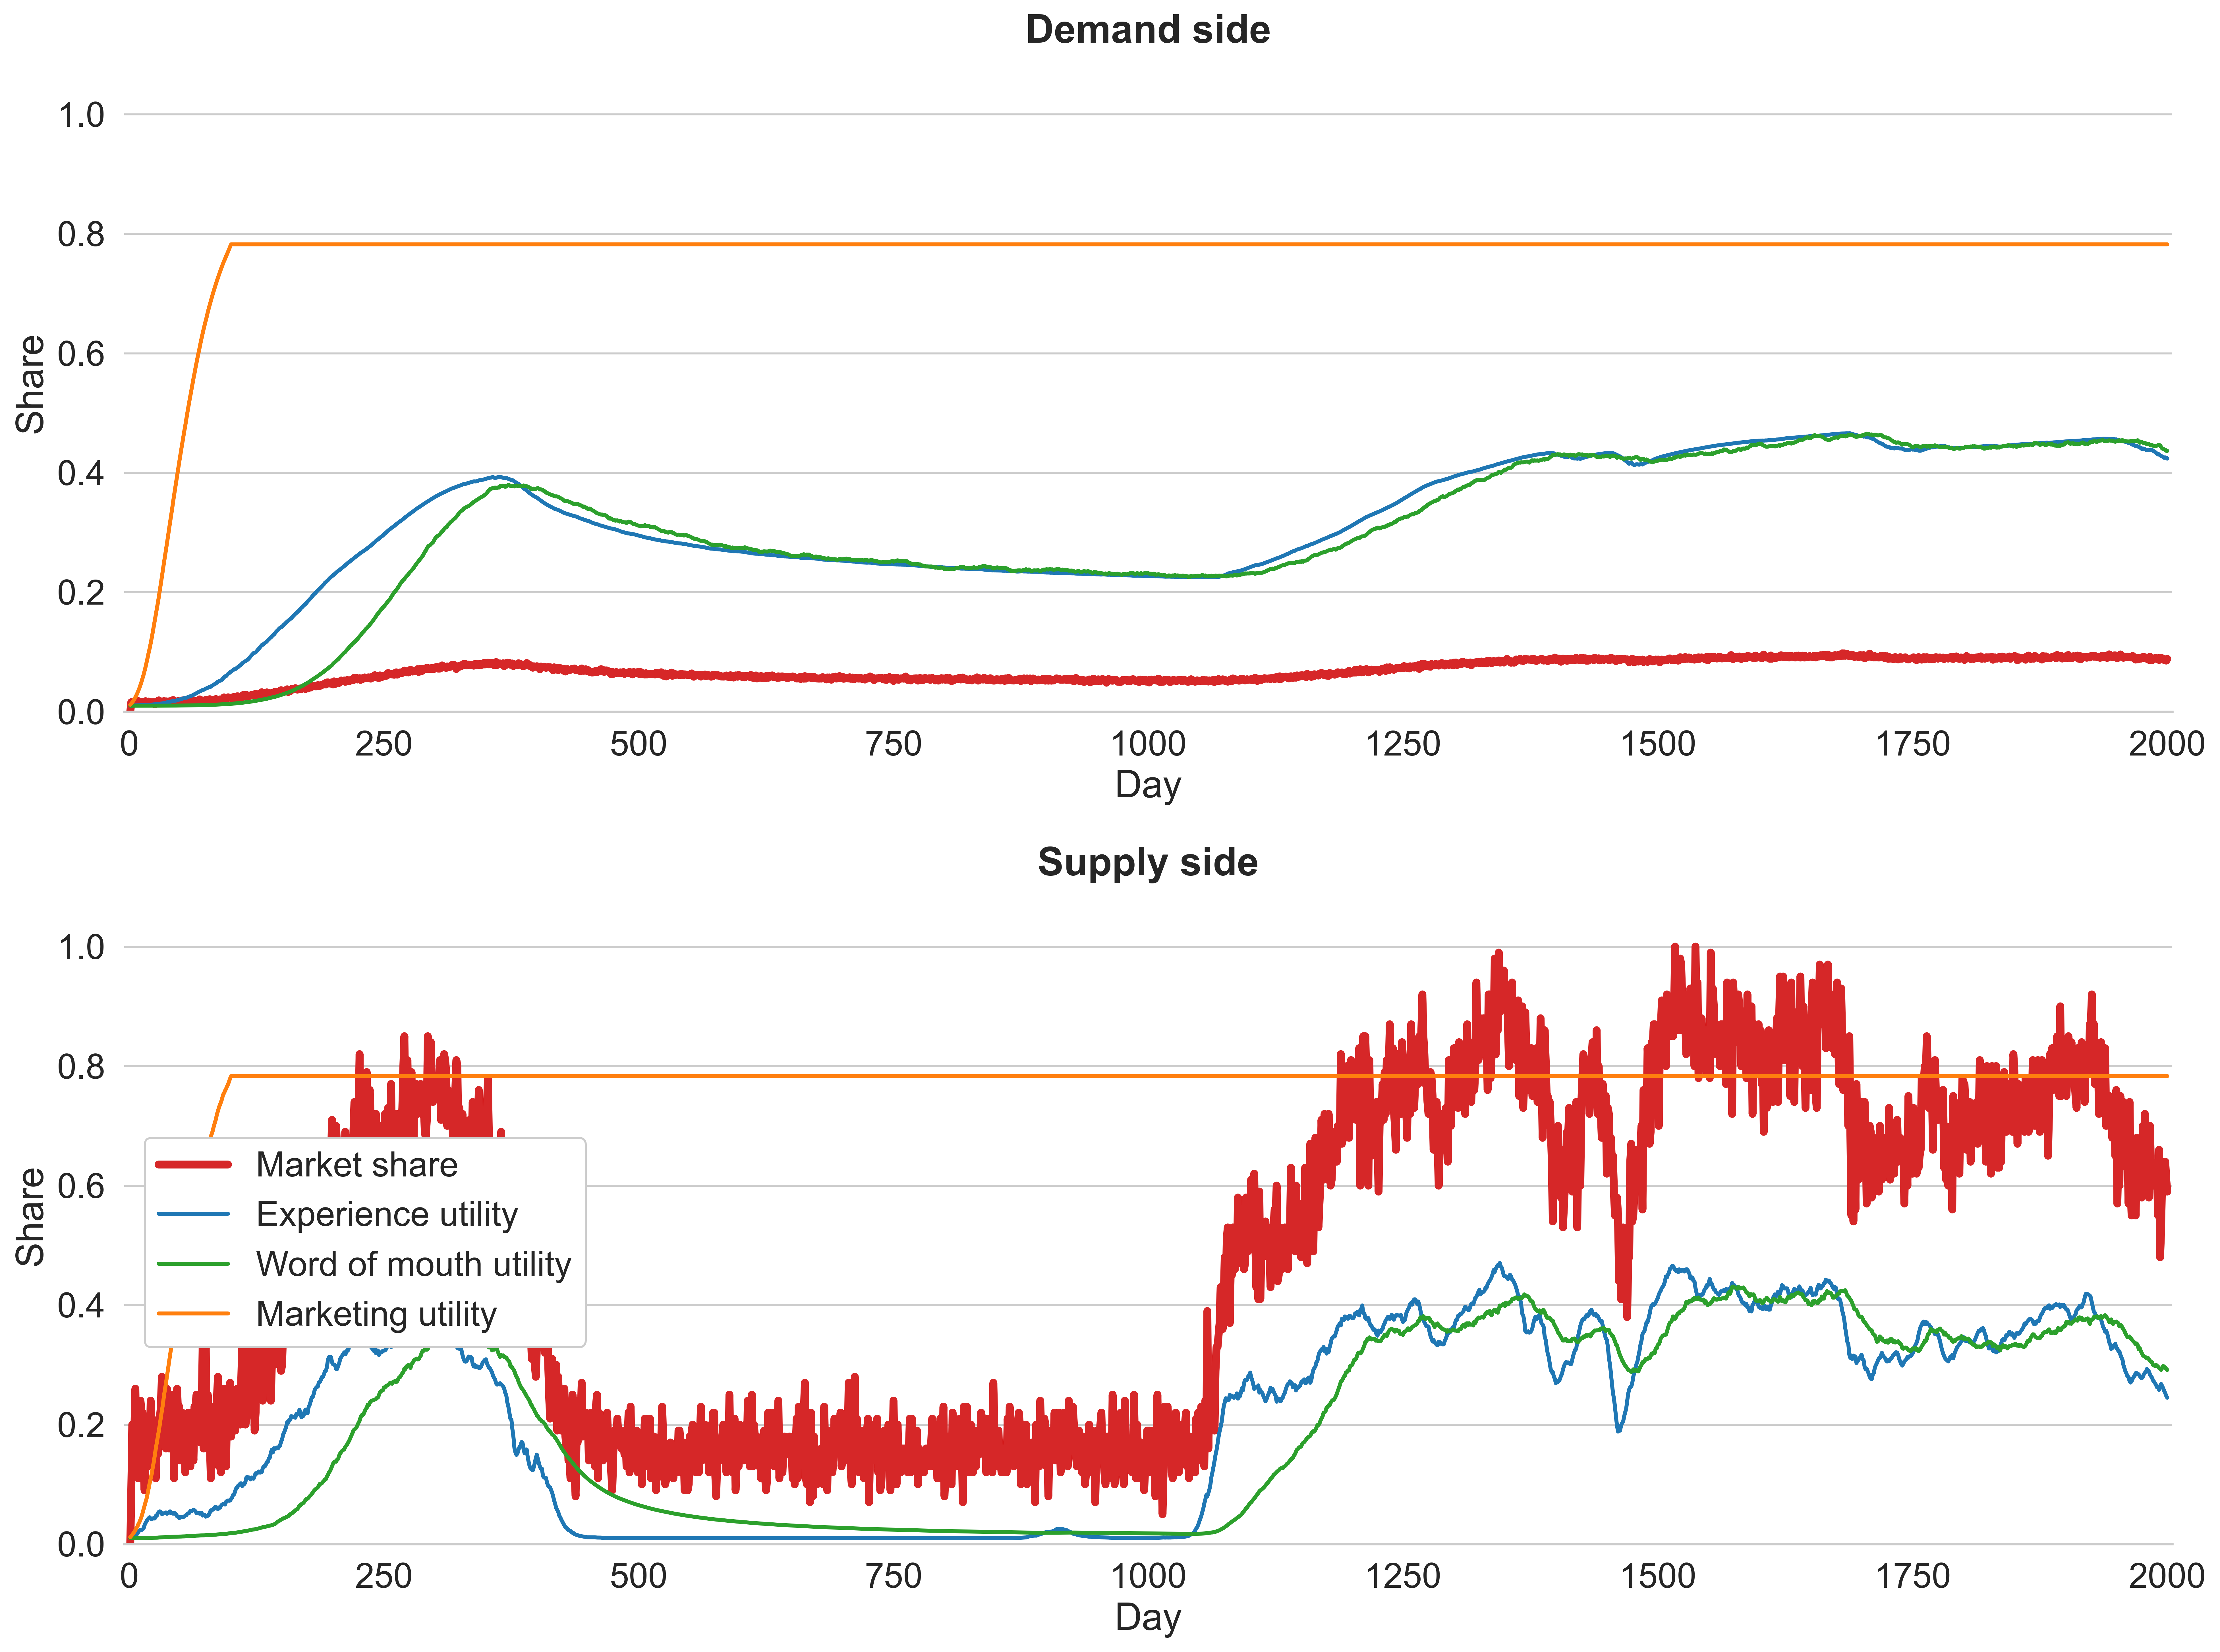

In [11]:
# np 10000, nv 1000, fare 1.2 euro, simtime 4, .d2d.m = 7

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
params.nD=2000
params.nP=10000
params.nV=100
for row in range(0,2):
    
    if row==0:
        df=df_d; n=params.nP; label='Demand side'
    elif row==1:
        df = df_s; n = params.nV; label='Supply side'
        
    lx = [i for i in range(1,params.nD+1)]
    sns.lineplot(x=lx, y=df.OUT/n, label = 'Market share', color='C3', lw=4, ax=ax[row])
    sns.lineplot(x=lx, y=df.EXPERIENCE_U, label = 'Experience utility', color='C0', lw=2, ax=ax[row])
    sns.lineplot(x=lx, y=df.WOM_U, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[row])
    sns.lineplot(x=lx, y=df.MARKETING_U, label = 'Marketing utility', color='C1', lw=2, ax=ax[row])

    ax[row].grid(axis='x')
    ax[row].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,params.nD+5))
    ax[row].set_title(label,fontweight='bold', loc='center',fontsize=20)

ax[1].legend(frameon=True,framealpha=1, loc=(0.01,0.3))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
# ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
# for i in range(0,6):
#     value = ['I','II','III','IV','V','VI']
#     coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
#     ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()

In [31]:
df.working_U

0           NaN
1     -0.400000
2      0.010703
3      0.011801
4      0.011921
         ...   
995    0.010022
996    0.010023
997    0.010029
998    0.010028
999    0.010031
Name: working_U, Length: 1000, dtype: float64

In [ ]:
if mu>10 and UW=0.1

In [250]:
import math
working_U = -0.2
not_working_U = 0.5
params.d2d.m = 5

(math.exp(params.d2d.m*working_U))/(math.exp(params.d2d.m*working_U) + math.exp(params.d2d.m*not_working_U))

0.02931223075135632

In [9]:
200*0.07585818002124355

15.17163600424871

In [ ]:
mout_1: lr=0.001, stp=0.05, bs=32
mout_2: lr=0.0001, stp=0.05, bs=8
mout_3: lr=0.0001, stp=0.05, bs=8, 1% of supply for comm_rate=100%
mout_4: lr=0.0001, stp=0.05, bs=8, commission added to state
mout_5: lr=0.0001, stp=0.01, bs=16, commission added to state
mout_6: lr=0.001, stp=0.05, bs=16, commission added to state, market share added to reward
mout_7: lr=0.001, stp=0.05, bs=16, commission added to state, market share added to reward, 1000 days
mout_8: lr=0.001, stp=0.05, bs=16, commission added to state, market share added to reward, 1000 days
mout_9: lr=0.0001, stp=0.05, bs=16, commission added to state, market share added to reward, 1000 days
mout_10: lr=0.0001, stp=0.05, bs=16, revenue with 1/2 weight--> not good
mout_11: lr=0.0001, stp=0.05, bs=16, revenue with 3/5 weight--> not good
mout_12: lr=0.0001, stp=0.05, bs=16, reward only market share
mout_13: lr=0.0001, stp=0.05, bs=32, epsilon decay=0.99, learn each 5 days




batch size 32
maybe max-revenue is the problem it should be fixed
it seems comm_rate did not change anything as a part of state. I can normalize them all

1. try adjusting the commission rate each x days. 
2. consider 50% threshold for the commission rate. No need
3. add market share to reward. Worked well.

---------------------
1. normalizing the state (nP and nV) made the results worse
2. increasing the weight of the revenue in reward function made the model worse.
3. batch size 32 and higher gives memory error!

In [ ]:
Best model:

1. lr = 0.0001
2. 

0.94

In [11]:
prev_comm_rate = sim.platforms.comm_rate[1]
comm_rate = prev_comm_rate

comm_rate = comm_rate+0.05
sim.platforms.comm_rate[1] = comm_rate

In [14]:
sim.platforms.comm_rate[1]

1.0

In [17]:
np.reshape(np.asarray([0, 0]), [1, 2])

array([[0, 0]])

In [6]:
max_revenue = 0

In [9]:
revenue = 12

max_revenue = revenue if revenue>max_revenue else max_revenue # Euro per day
max_revenue

12

In [9]:
0%10

0